In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 

get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:

confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-23-2020.csv')

In [3]:
cols = confirmed_df.keys()

In [4]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]


In [5]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 


In [6]:
for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)


In [7]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

In [8]:
# confirmed cases
world_daily_increase = daily_increase(world_cases)

# deaths
world_daily_death = daily_increase(total_deaths)

# recoveries
world_daily_recovery = daily_increase(total_recovered)


In [9]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]


In [10]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [11]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.08, shuffle=False)
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(days_since_1_22, total_deaths, test_size=0.08, shuffle=False) 


C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MAE: 33327173.12015405
MSE: 1204157722364382.8


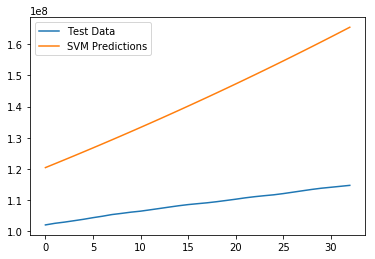

In [12]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))


In [17]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)


MAE: 9034188.883461058
MSE: 102313520822545.5


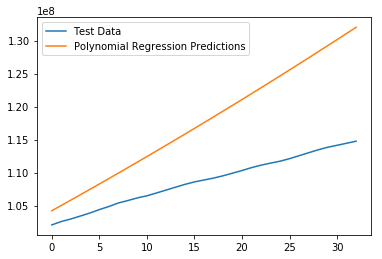

In [22]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

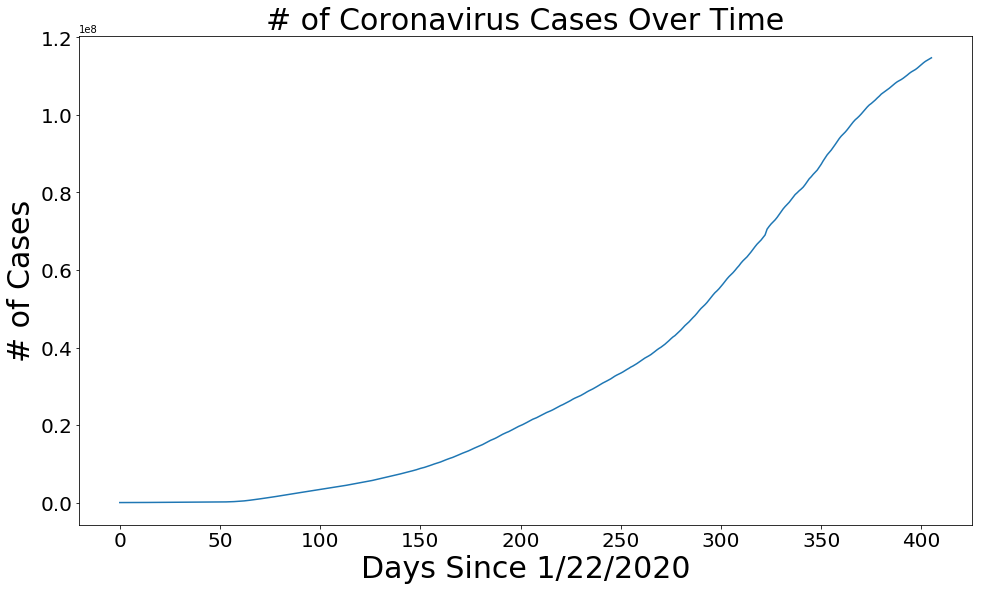

In [23]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


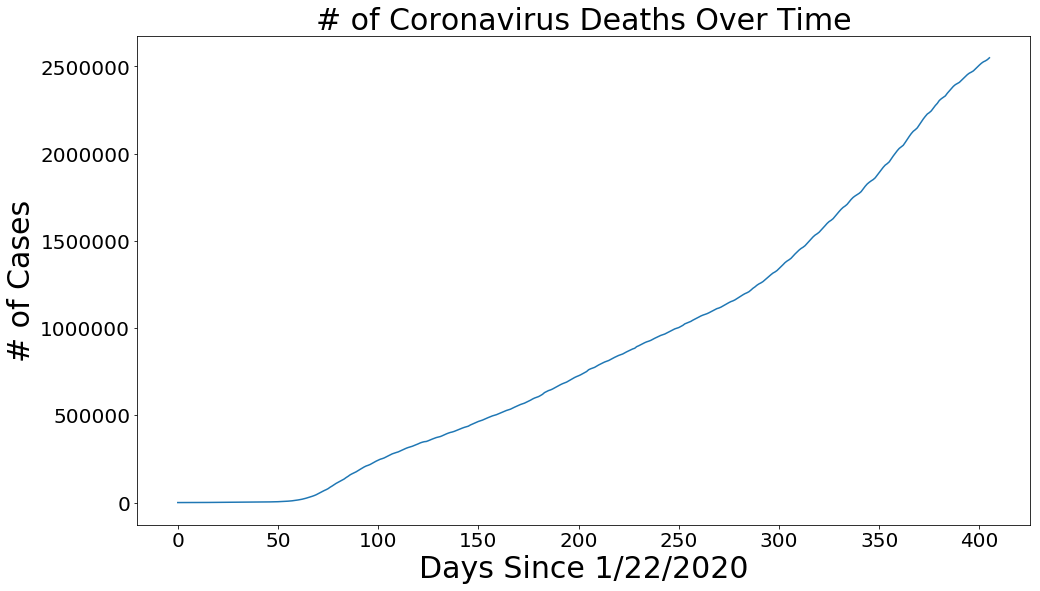

In [24]:

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths)
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


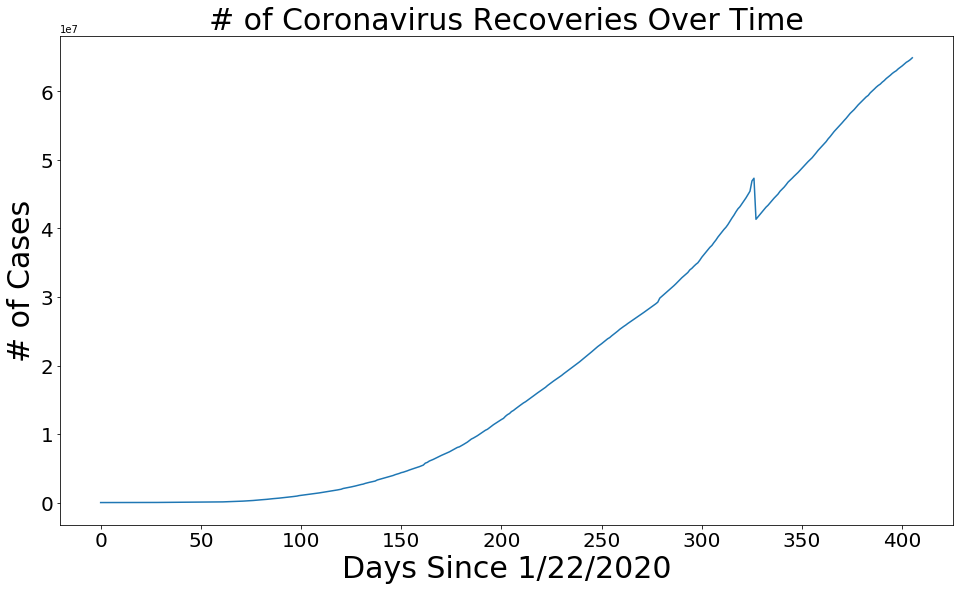

In [25]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_recovered)
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

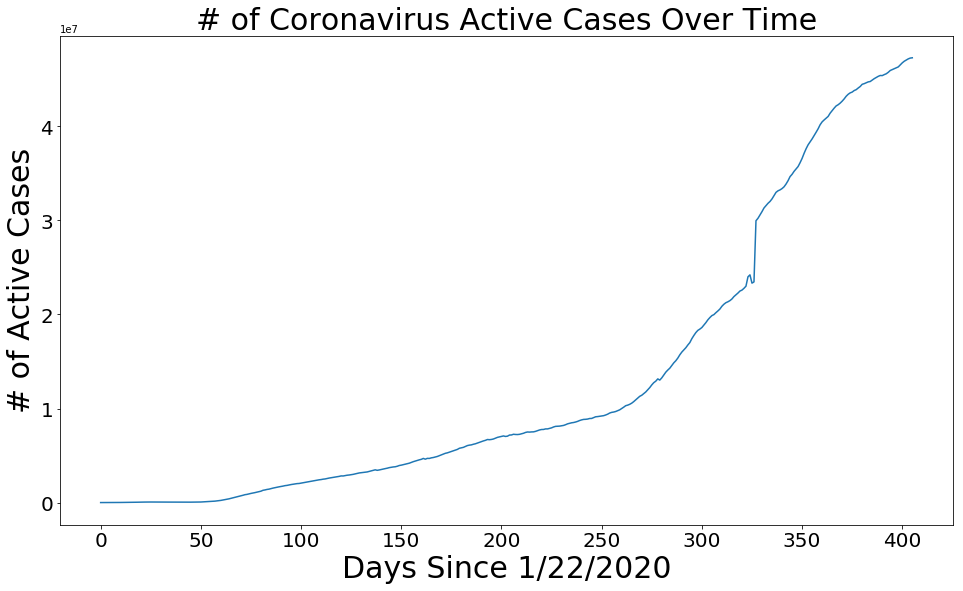

In [26]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_active)
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


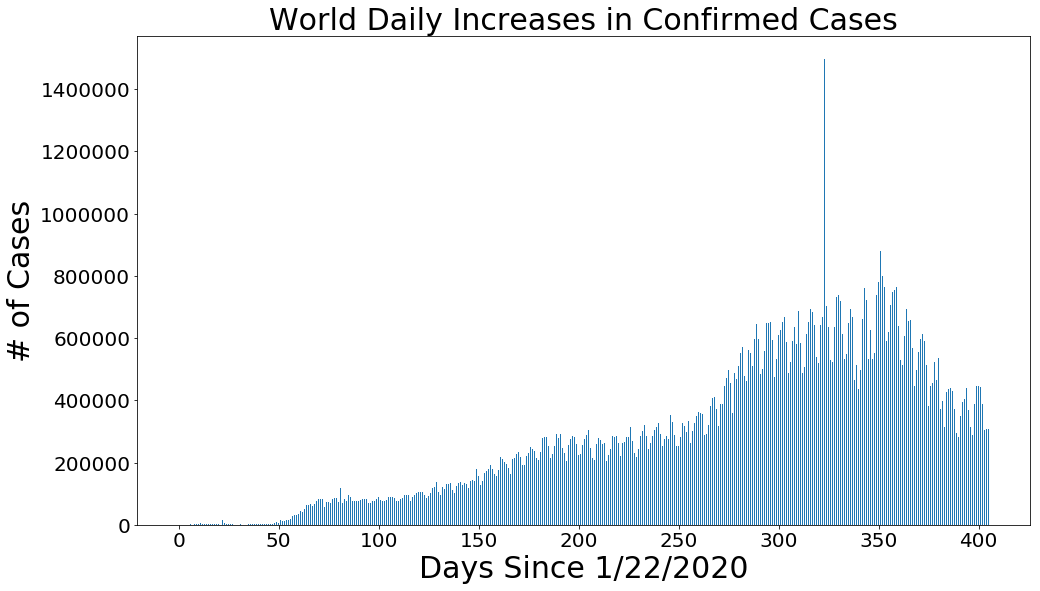

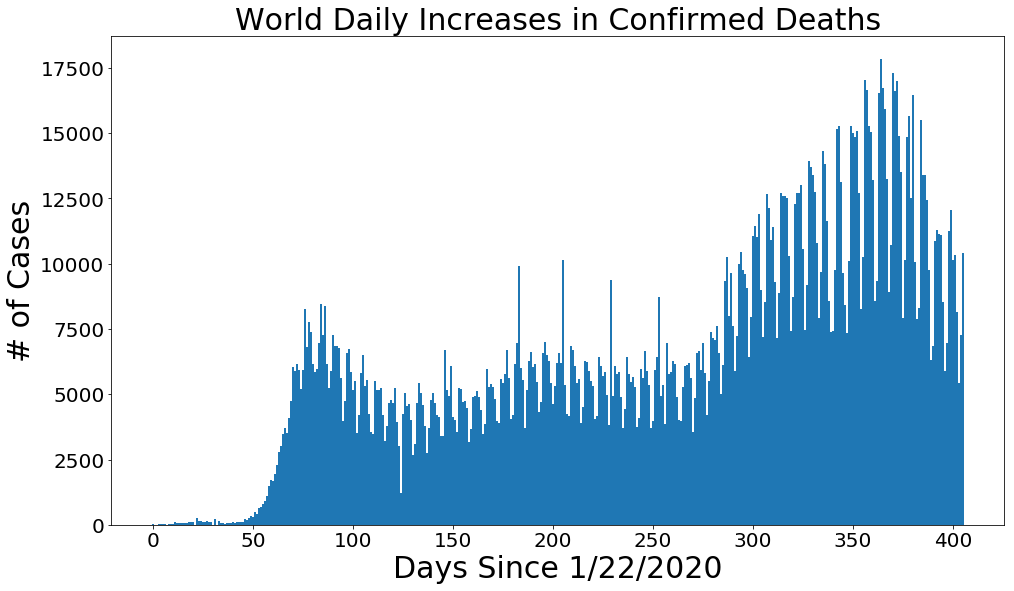

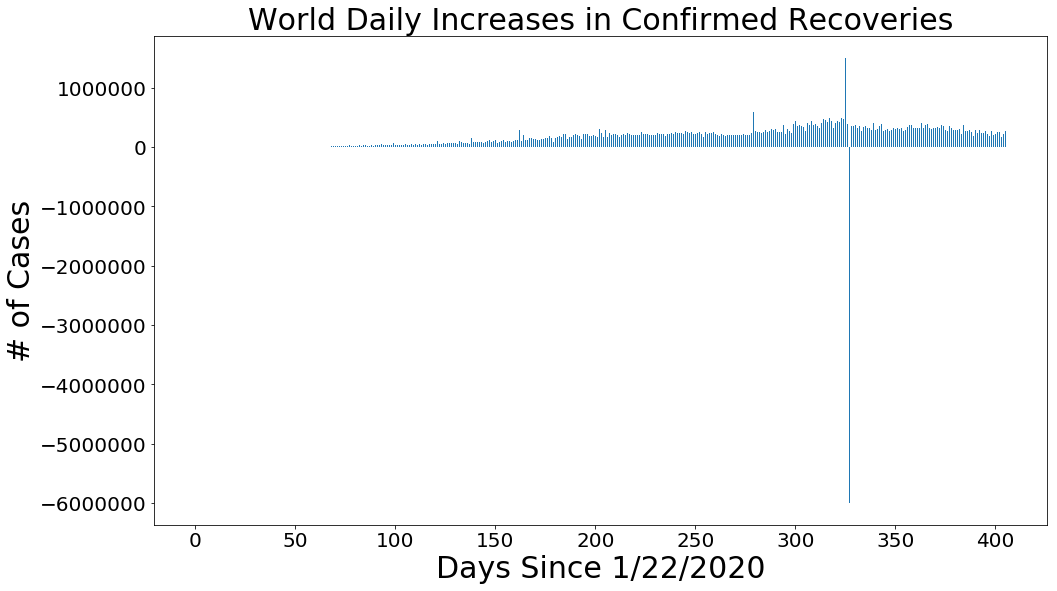

In [27]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_death)
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_recovery)
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [28]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

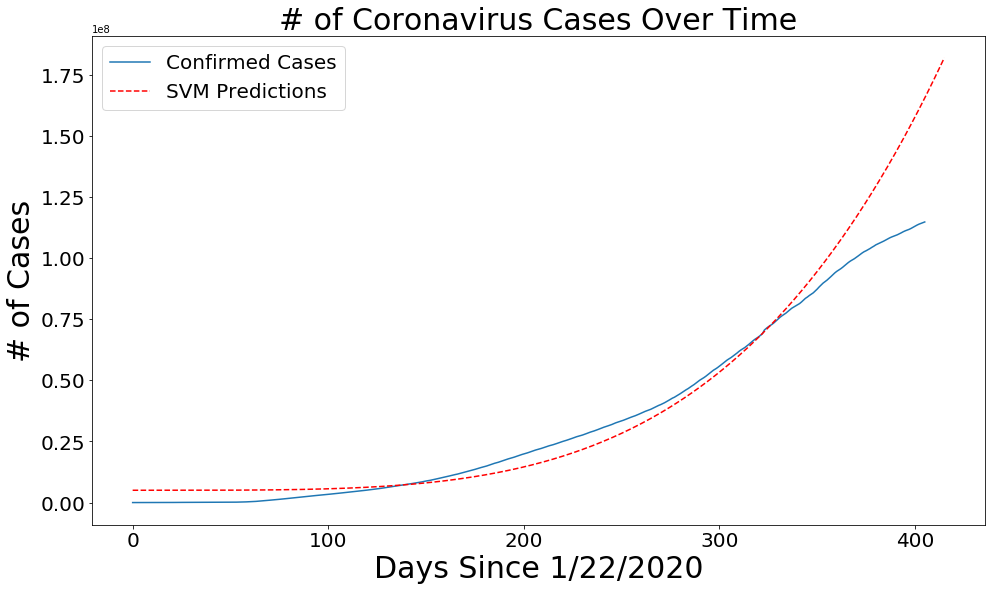

In [29]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'red')



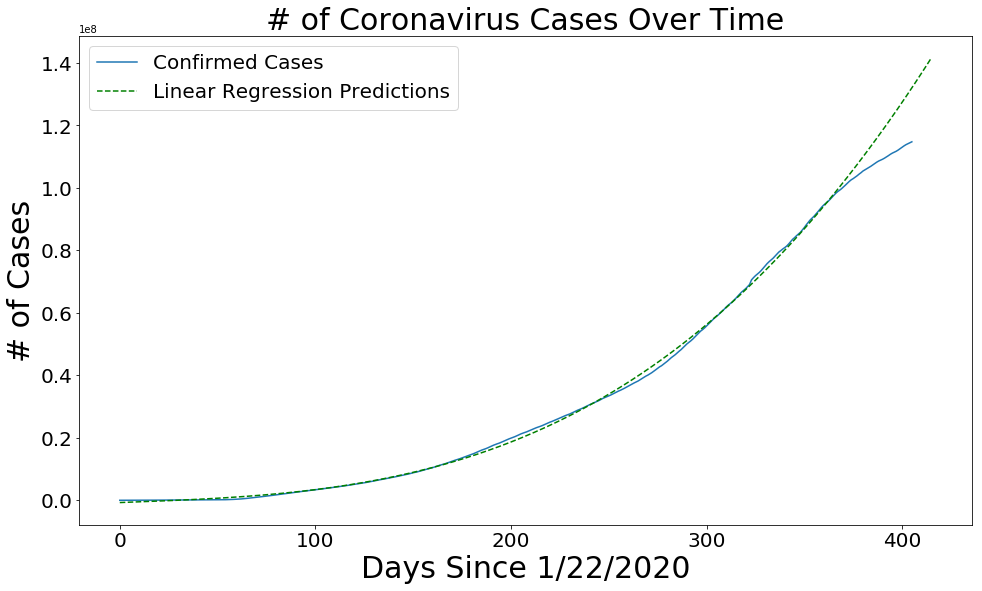

In [30]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Linear Regression Predictions', 'green')


In [31]:
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df


,Date,SVM Predicted # of Confirmed Cases Worldwide
0,03/03/2021,167035083.0
1,03/04/2021,168637074.0
2,03/05/2021,170250916.0
3,03/06/2021,171876669.0
4,03/07/2021,173514391.0
5,03/08/2021,175164139.0
6,03/09/2021,176825974.0
7,03/10/2021,178499954.0
8,03/11/2021,180186137.0
9,03/12/2021,181884584.0


In [32]:
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
svm_df



,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,03/03/2021,132957268.0
1,03/04/2021,133903435.0
2,03/05/2021,134854162.0
3,03/06/2021,135809460.0
4,03/07/2021,136769340.0
5,03/08/2021,137733813.0
6,03/09/2021,138702890.0
7,03/10/2021,139676584.0
8,03/11/2021,140654904.0
9,03/12/2021,141637863.0


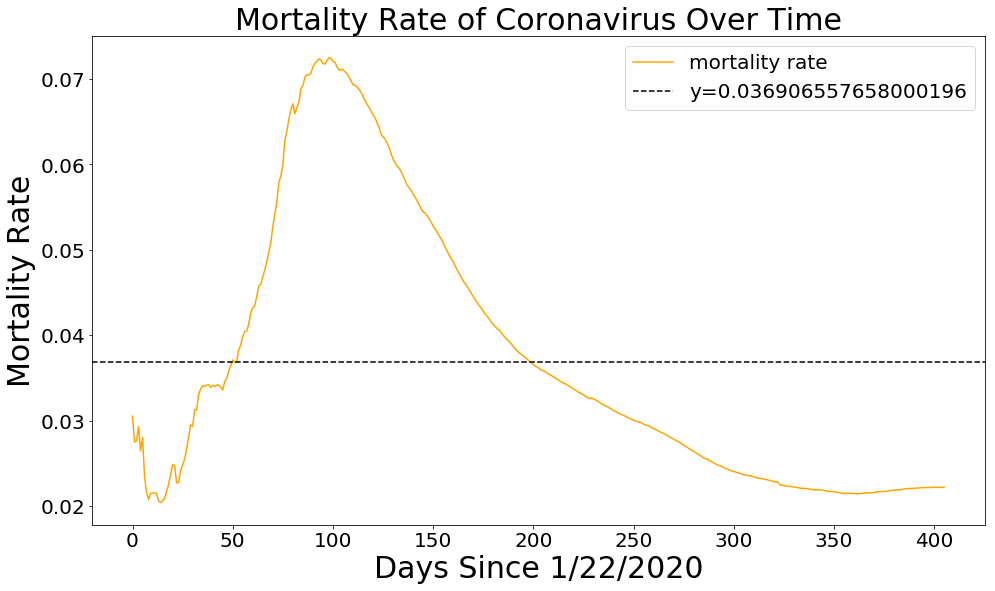

In [33]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


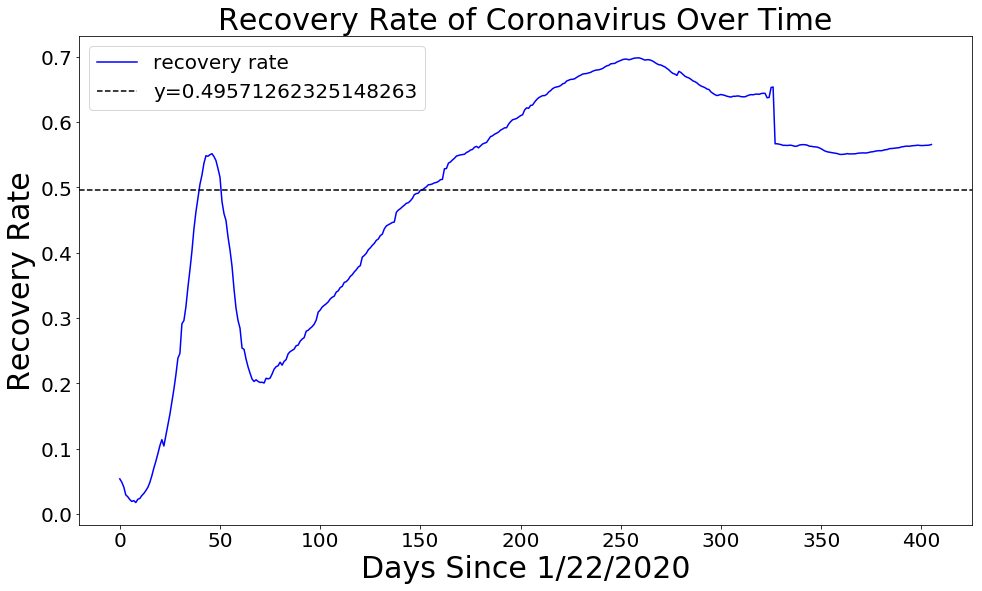

In [34]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

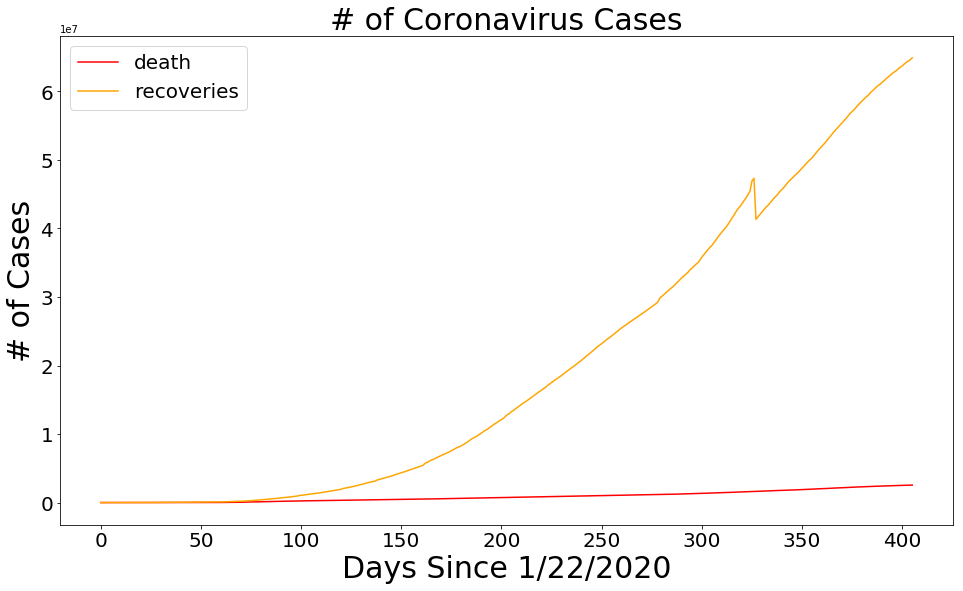

In [35]:


plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='orange')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()



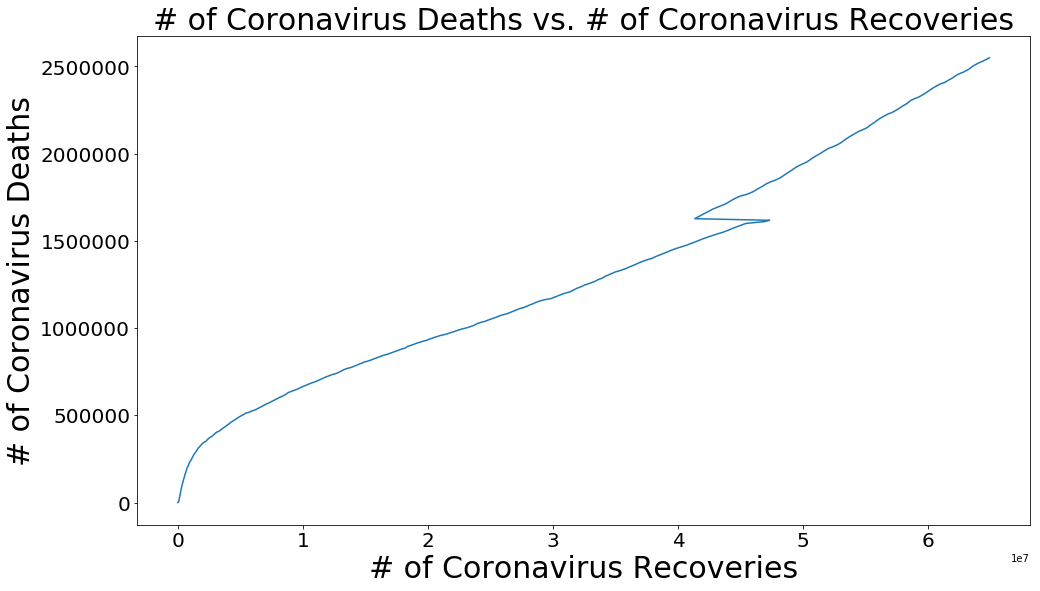

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,55604,55617,55646,55664,55680,55696,55707,55714,55733,55759
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,100246,101285,102306,103327,104313,105229,106215,107167,107931,108823
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,111917,112094,112279,112461,112622,112805,112960,113092,113255,113430
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,10699,10712,10739,10775,10799,10822,10849,10866,10889,10908
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,20519,20548,20584,20640,20695,20759,20782,20807,20854,20882


In [36]:

plt.figure(figsize=(16, 9))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

confirmed_df.head()

In [37]:
from sklearn.linear_model import LinearRegression, BayesianRidge


In [38]:
bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [39]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [40]:
bayesian_search.best_params_

{'tol': 1e-05,
 'normalize': True,
 'lambda_2': 1e-07,
 'lambda_1': 0.001,
 'alpha_2': 1e-06,
 'alpha_1': 0.0001}

In [41]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 9989667.773324009
MSE: 123447569923254.73


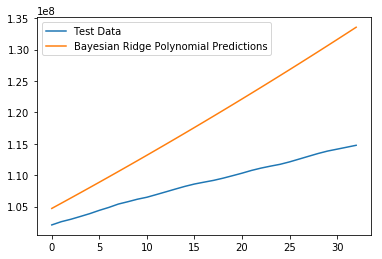

In [45]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

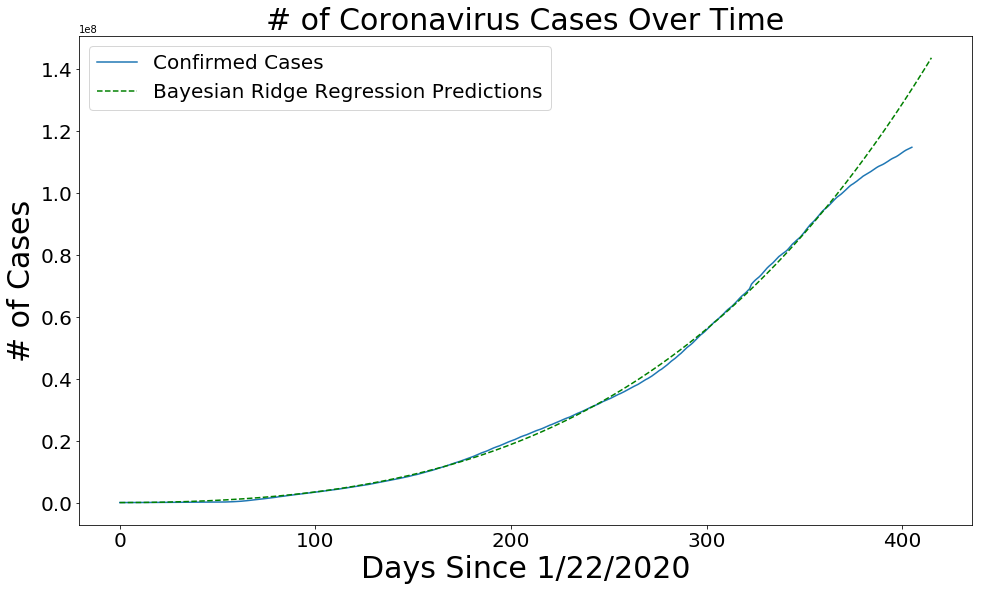

In [46]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [47]:
# Future predictions using Bayesian Ridge 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
svm_df

,Date,Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0,03/03/2021,134537519.0
1,03/04/2021,135528602.0
2,03/05/2021,136525009.0
3,03/06/2021,137526760.0
4,03/07/2021,138533874.0
5,03/08/2021,139546370.0
6,03/09/2021,140564265.0
7,03/10/2021,141587581.0
8,03/11/2021,142616334.0
9,03/12/2021,143650544.0


In [48]:

india_cases=[]
india_deaths=[]
india_recovered=[]

for i in dates:
    india_cases.append(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    india_deaths.append(deaths_df[deaths_df['Country/Region']=='India'][i].sum())
    india_recovered.append(recoveries_df[deaths_df['Country/Region']=='India'][i].sum())
   
   

C:\Users\pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [49]:
india_daily_increase=daily_increase(india_cases)
india_daily_death=daily_increase(india_deaths)
india_daily_recovered=daily_increase(india_recovered)


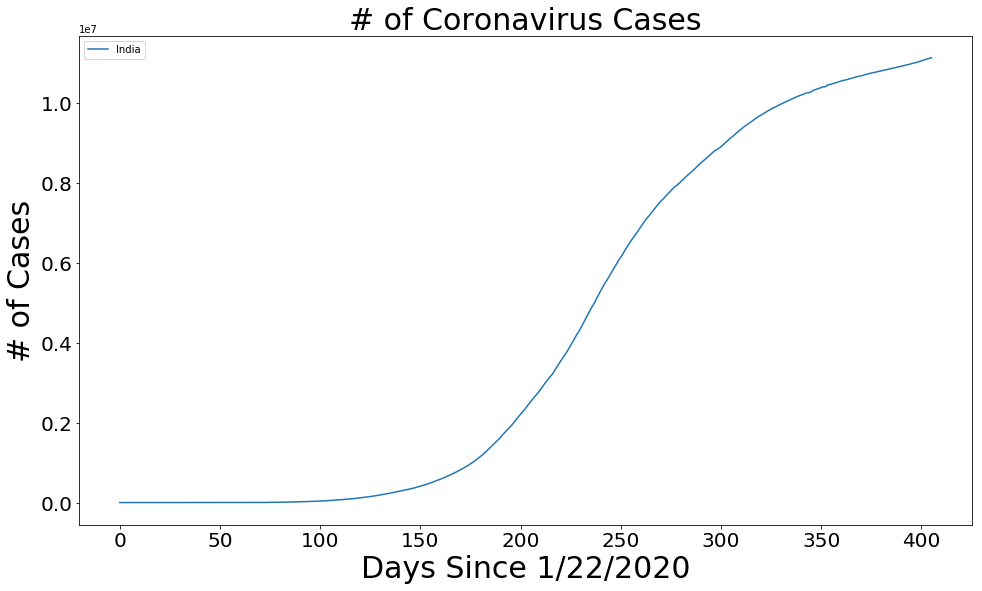

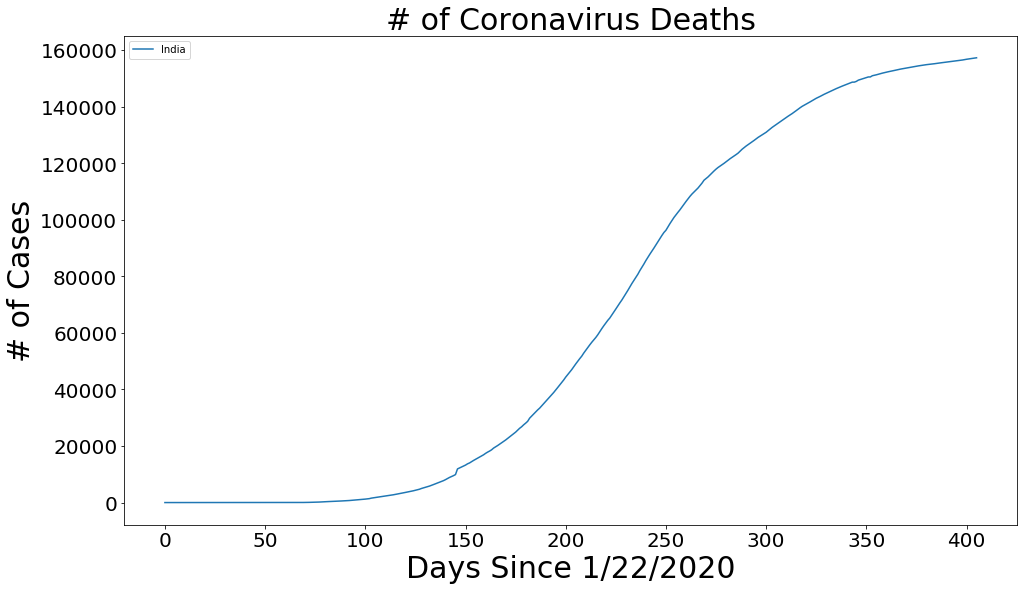

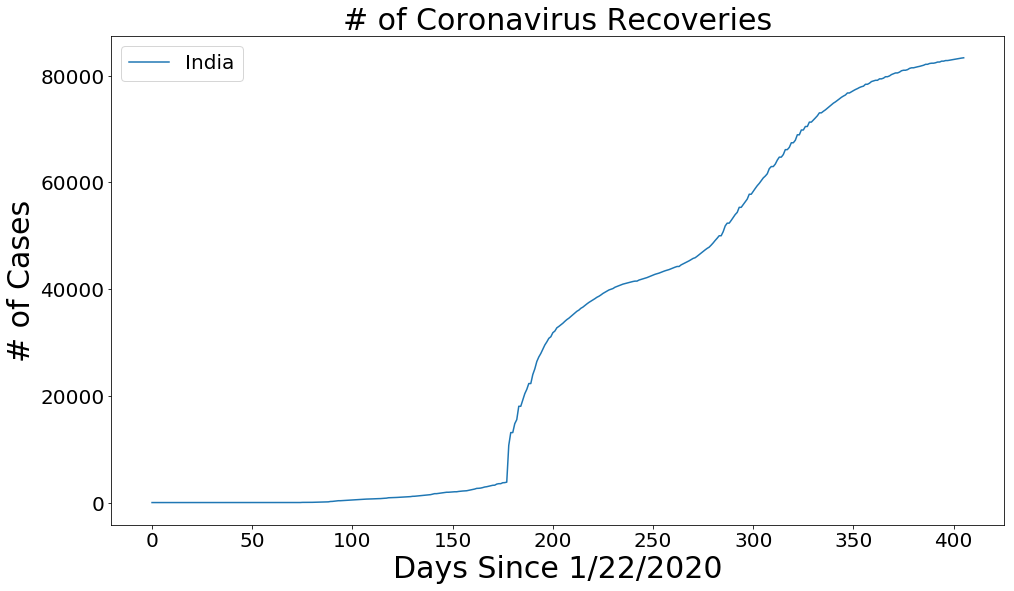

In [50]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, india_cases)

plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['India'])
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, india_deaths)


plt.title('# of Coronavirus Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['India'])
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, india_recovered)
plt.title('# of Coronavirus Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['India'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [51]:
unique_countries =  list(latest_data['Country_Region'].unique())


In [52]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)

unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])


In [53]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})


country_df.style.background_gradient(cmap='Blues')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,869856,50376,80203,739277,0.057913
1,Spain,213024,22157,89250,101617,0.104012
2,Italy,189973,25549,57576,106848,0.134488
3,France,158315,21860,42762,93693,0.138079
4,Germany,153129,5575,103300,44254,0.0364072
5,United Kingdom,139246,18791,712,119743,0.134948
6,Turkey,101790,2491,18491,80808,0.024472
7,Iran,87026,5481,64843,16702,0.0629812
8,China,83884,4636,77983,1265,0.0552668
9,Russia,62773,555,4891,57327,0.00884138


In [54]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, india_cases, test_size=0.08, shuffle=False)
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(days_since_1_22, india_deaths, test_size=0.08, shuffle=False) 


In [64]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
#svm_test_pred = svm_confirmed.predict(X_test_confirmed)

print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

MAE: 9109246.203065744
MSE: 86359231491252.86


In [56]:
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)


In [57]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))


MAE: 1015694.4414313075
MSE: 1044101144692.8276


In [58]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

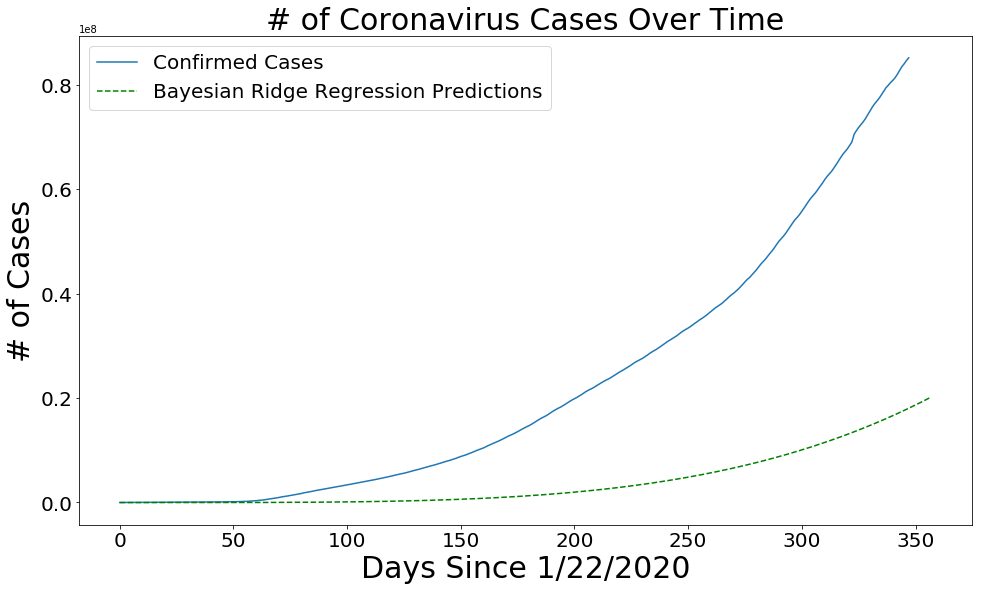

In [58]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'Bayesian Ridge Regression Predictions', 'green')